In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
data = pd.read_csv('/kaggle/input/ip-network-traffic-flows-labeled-with-87-apps/Dataset-Unicauca-Version2-87Atts.csv')

In [14]:
# Selecting only numeric columns for outlier detection
numeric_cols = ['Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets', 
                'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
                'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std',
                'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Mean', 'Bwd.Packet.Length.Std',
                'Flow.Bytes.s', 'Flow.Packets.s']

# Creating a new DataFrame with numeric features only
numeric_data = data[numeric_cols]

In [15]:
numeric_data.head(5)

,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Packet.Length.Max,Fwd.Packet.Length.Mean,Fwd.Packet.Length.Std,Bwd.Packet.Length.Max,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Std,Flow.Bytes.s,Flow.Packets.s
0,45523,22,55,132,110414.0,6,6.000000,0.000000,4380,2007.527273,768.481689,2.428355e+06,1.691453e+03
1,1,2,0,12,0.0,6,6.000000,0.000000,0,0.000000,0.000000,1.200000e+07,2.000000e+06
2,1,3,0,674,0.0,337,224.666667,194.567041,0,0.000000,0.000000,6.740000e+08,3.000000e+06
3,217,1,3,0,0.0,0,0.000000,0.000000,0,0.000000,0.000000,0.000000e+00,1.843318e+04
4,78068,5,0,1076,0.0,529,215.200000,286.458898,0,0.000000,0.000000,1.378286e+04,6.404673e+01


In [16]:
# Or use iloc to be explicit
subset_data = numeric_data.iloc[:10000]

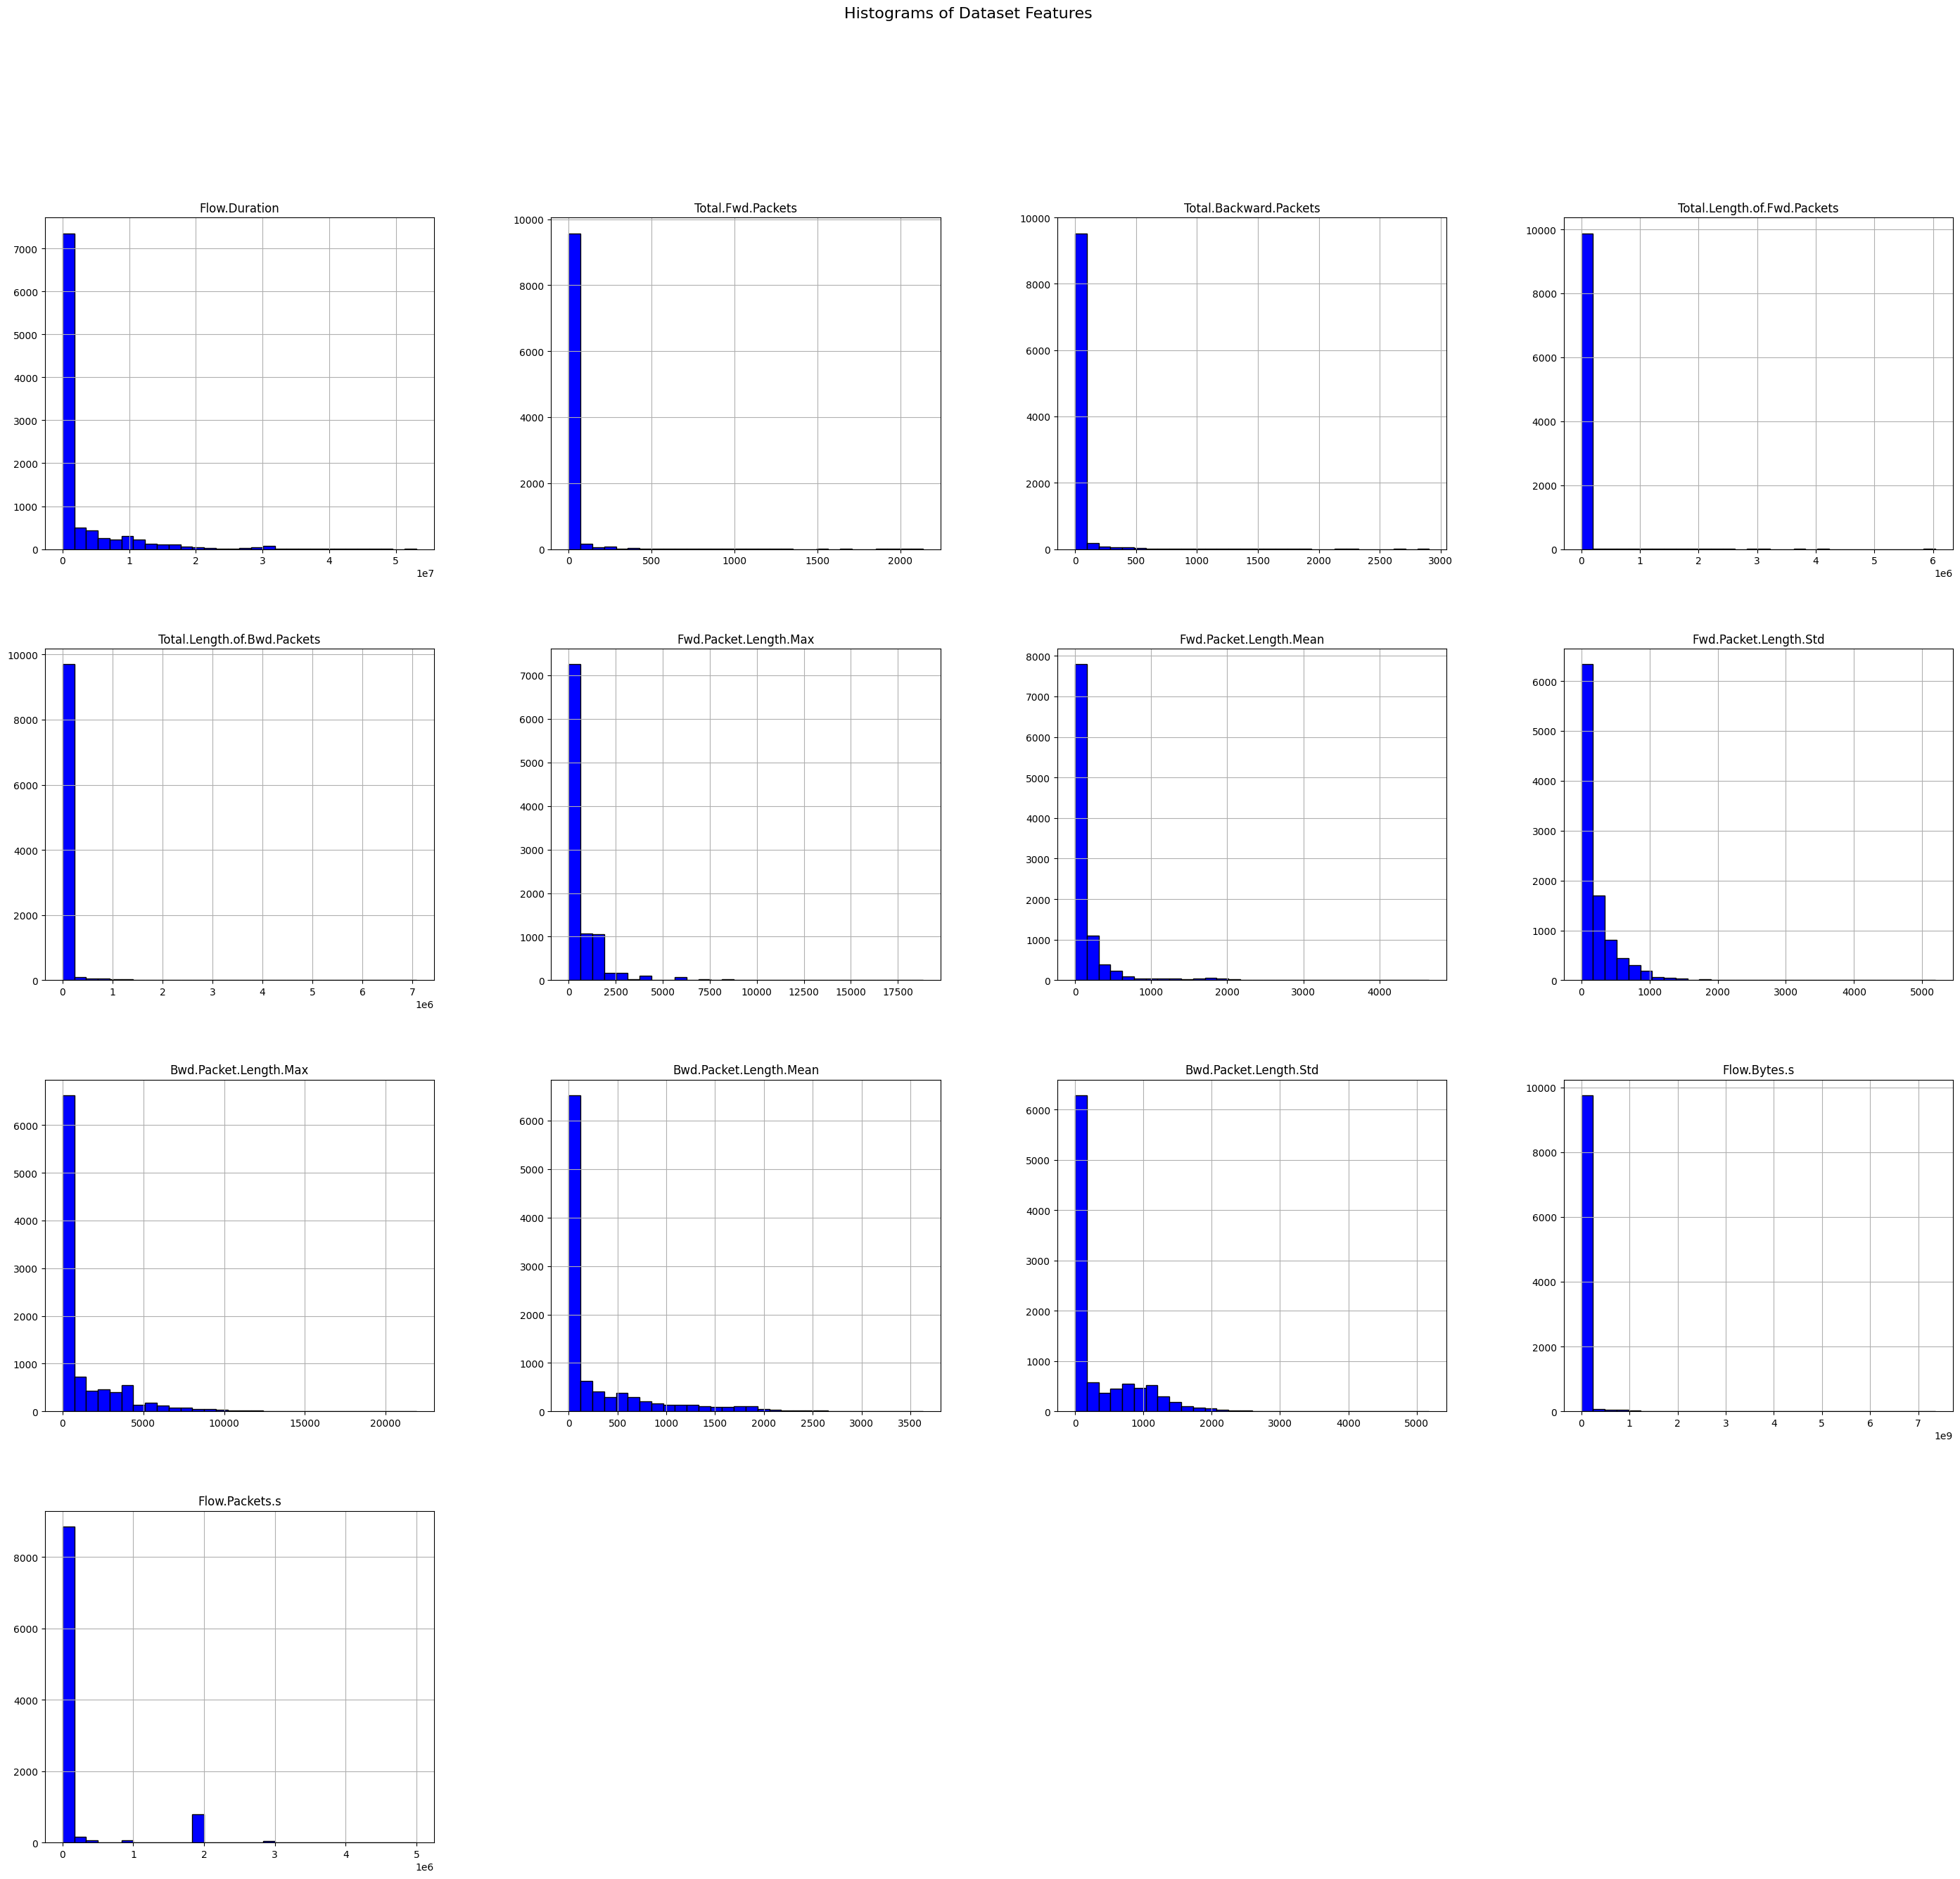

In [17]:
# Plot heatmap to visualize correlation between features
# Plot histograms for all features
subset_data.hist(bins=30, figsize=(35, 30), color='blue', edgecolor='black')
plt.suptitle('Histograms of Dataset Features', fontsize=16)
plt.show()

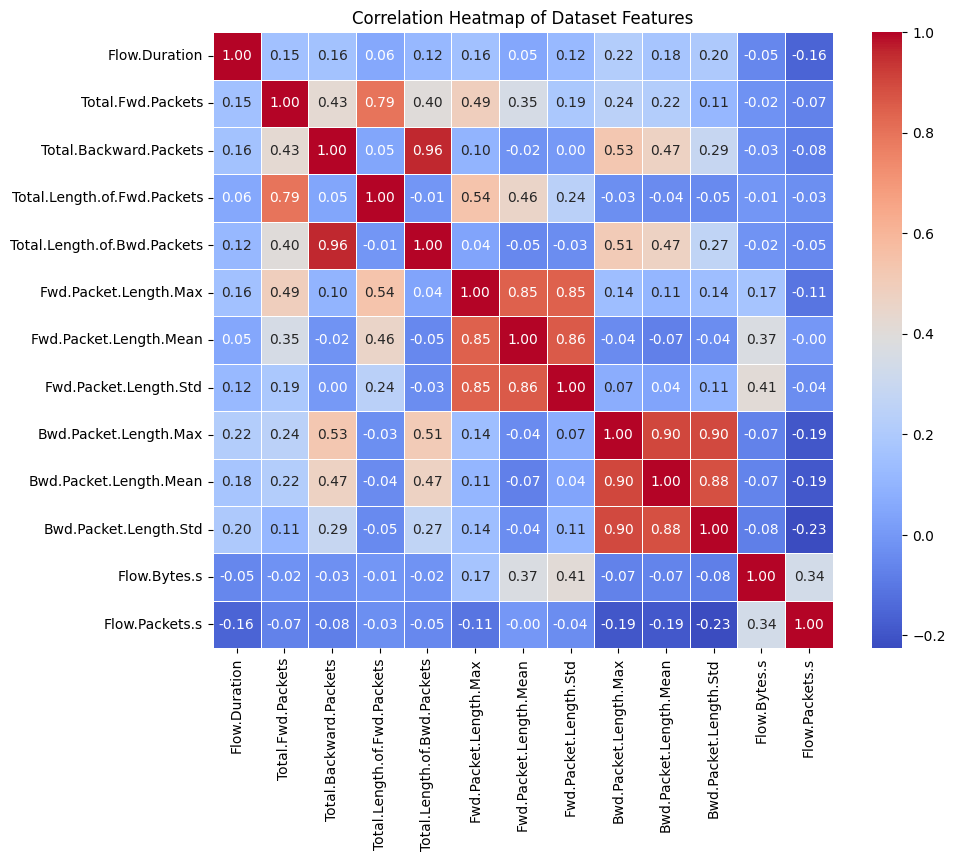

In [18]:
# Plot heatmap to visualize correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(subset_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Dataset Features')
plt.show()

# Z score outlier detection

In [23]:
# Compute Z-scores for all features in the numeric dataset
z_scores = np.abs((subset_data - subset_data.mean()) / subset_data.std())

# Define a threshold for anomalies (e.g., Z-score > 3)
threshold = 3

# Identify outliers: If any feature in a row exceeds the threshold, mark the row as an outlier
outliers = (z_scores > threshold).any(axis=1)

# Add the outliers to the original DataFrame
subset_data.loc[:, 'Outlier_Statistical'] = outliers

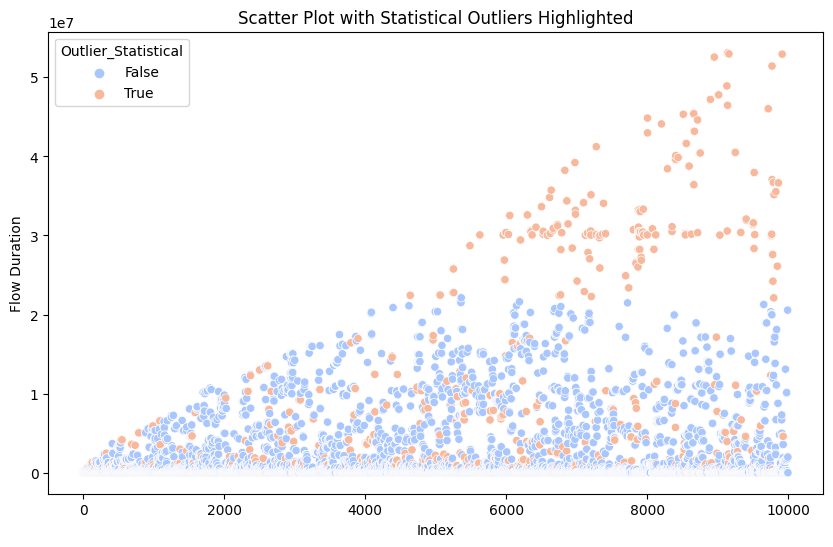

In [25]:
# Scatter plot with outliers highlighted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=subset_data.index, y=subset_data['Flow.Duration'], hue=subset_data['Outlier_Statistical'], palette='coolwarm')
plt.title('Scatter Plot with Statistical Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Flow Duration')
plt.show()

**Isolation Forest Outlier Detection**

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_30/4291957582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Outlier_IsolationForest'] = (iso_pred == -1)


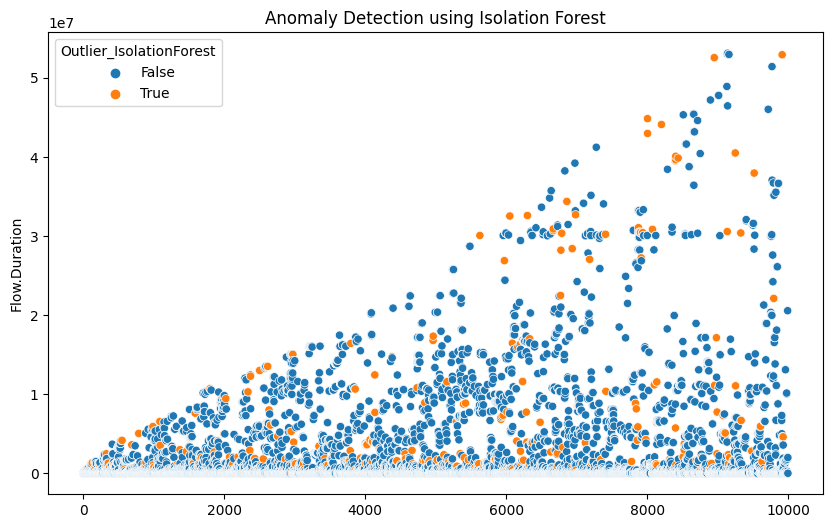

In [26]:
# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05)  # 5% contamination rate
iso_pred = iso_forest.fit_predict(subset_data)

# -1 for anomalies, 1 for normal points
subset_data['Outlier_IsolationForest'] = (iso_pred == -1)

# Visualize Isolation Forest anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=subset_data.index, y=subset_data.iloc[:, 0], hue=subset_data['Outlier_IsolationForest'])
plt.title('Anomaly Detection using Isolation Forest')
plt.show()


# SVM Classifier Outlier Detection

/tmp/ipykernel_30/1792180638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Outlier_SVM'] = (svm_pred == -1)


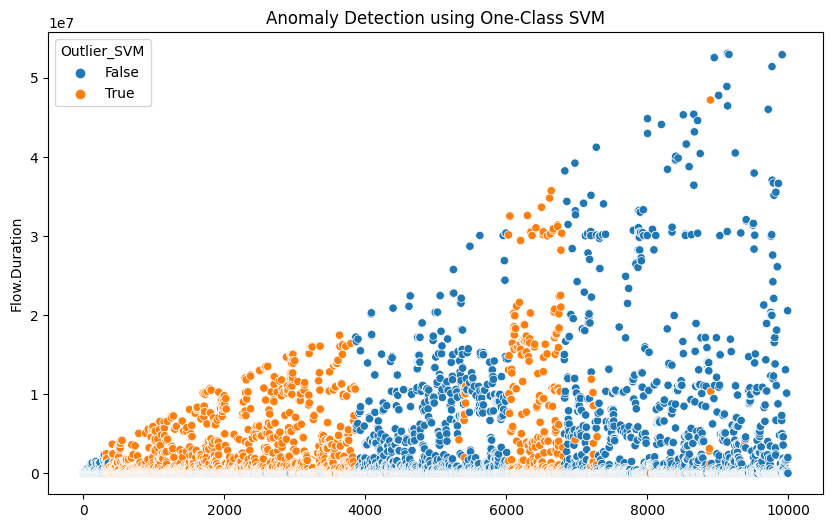

In [27]:
# Fit One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # nu is the upper bound on the fraction of outliers
svm_pred = oc_svm.fit_predict(subset_data)

# -1 for anomalies, 1 for normal points
subset_data['Outlier_SVM'] = (svm_pred == -1)

# Visualize One-Class SVM anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=subset_data.index, y=subset_data.iloc[:, 0], hue=subset_data['Outlier_SVM'])
plt.title('Anomaly Detection using One-Class SVM')
plt.show()

In [29]:
# Convert prediction (-1 for outlier, 1 for normal) to binary (1 for outlier, 0 for normal)
iso_forest_preds = np.where(iso_pred == -1, 1, 0)
svm_preds = np.where(svm_pred == -1, 1, 0)

# Calculate percentage of outliers detected
iso_forest_outliers = np.mean(iso_forest_preds)
svm_outliers = np.mean(svm_preds)

print(f"Isolation Forest detected {iso_forest_outliers * 100:.2f}% outliers.")
print(f"One-Class SVM detected {svm_outliers * 100:.2f}% outliers.")

Isolation Forest detected 5.00% outliers.
One-Class SVM detected 39.07% outliers.


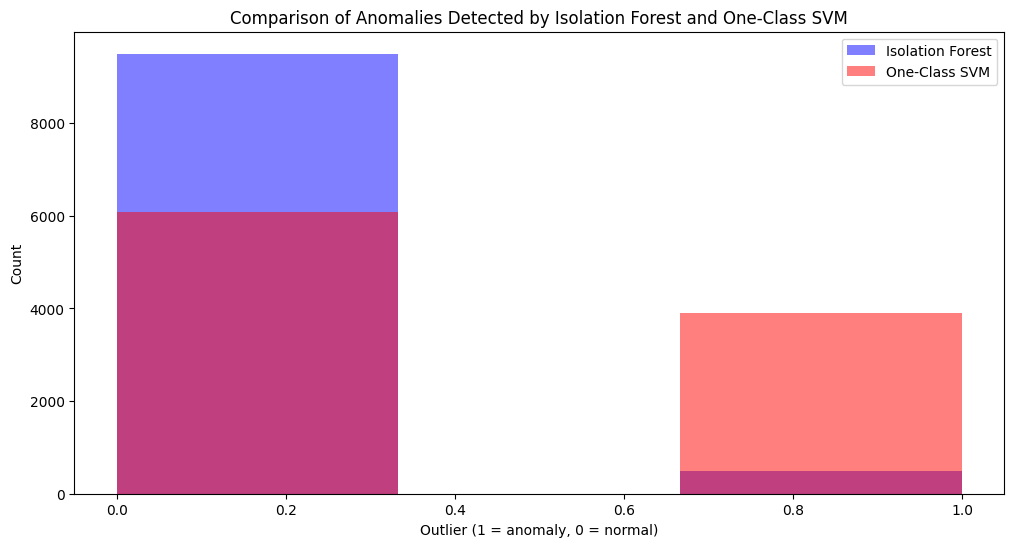

In [30]:
# Visualize the results (Distribution of anomalies detected)
plt.figure(figsize=(12, 6))
plt.hist(iso_forest_preds, bins=3, alpha=0.5, label='Isolation Forest', color='blue')
plt.hist(svm_preds, bins=3, alpha=0.5, label='One-Class SVM', color='red')
plt.legend()
plt.title('Comparison of Anomalies Detected by Isolation Forest and One-Class SVM')
plt.xlabel('Outlier (1 = anomaly, 0 = normal)')
plt.ylabel('Count')
plt.show()

* Blue areas: These areas show where only Isolation Forest classified data points (either as anomalies or normal), and One-Class SVM did not.
* Red areas: These areas show where only One-Class SVM classified the points.
* Purple areas: These areas indicate where both models agree on the classification of the data. Since the two histograms overlap and are semi-transparent, the combination of blue and red produces purple.